## Import packages:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import os
import urllib
import zipfile
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
from sklearn.feature_extraction import image
from tqdm import tqdm
sys.path.append('../../')

In [2]:
import numpy as np
import time
from glob import glob
from tifffile import imsave
from sklearn.cluster import MeanShift
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import pytorch_lightning as pl

In [3]:
import logging
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [4]:
import torch.optim as optim
from collections import OrderedDict
from torch.nn import init
import matplotlib.pyplot as plt
import datetime

In [5]:
dtype = torch.float
device = torch.device("cuda:0") 
print(device)

cuda:0


In [1]:
import network

## Download and load the DATA

In [7]:
i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')


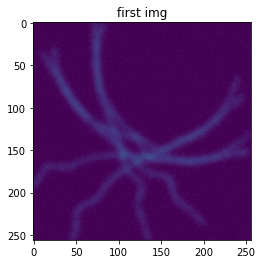

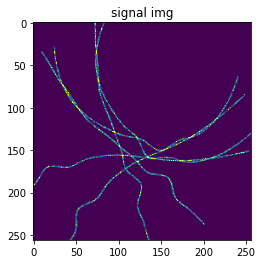

In [8]:
for i in range(1):
    plt.title(label='first img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='signal img')
    plt.imshow(signal[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

## Ploting functions

In [9]:
from math import log10, sqrt

def PSNR(original, compressed):
 mse = np.mean((original - compressed) ** 2)
 if(mse == 0):
  return 100
 max_pixel = np.max(original)
 psnr = 20 * log10(max_pixel / sqrt(mse))
#  print(psnr)
 return psnr 
 
def predict_mmse(vae, img, samples, device, returnSamples=False, tq=True): 
    '''
    Predicts MMSE estimate.
    Parameters

    '''
    img_height,img_width=img.shape[0],img.shape[1]
    imgT=torch.Tensor(img.copy())
    image_sample = imgT.view(1,1,img_height,img_width).to(device)
    vae.num_samples = samples
    all_samples = np.array(vae(image_sample,tqdm_bar=tq))
    samples_array = all_samples[:,0,0,:,:]
    if returnSamples:
        return np.mean(samples_array,axis=0), samples_array
    else:
        return np.mean(samples_array,axis=0)

100%|██████████| 100/100 [00:00<00:00, 473.44it/s]


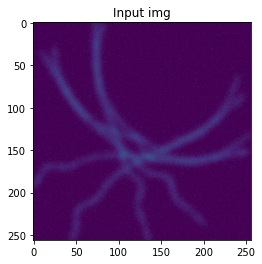

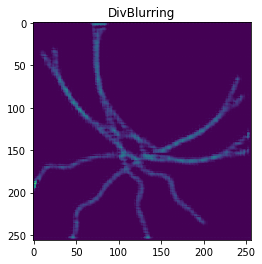

100%|██████████| 100/100 [00:00<00:00, 684.04it/s]


The mean value of PSNR 100 predictions:27.60013602588364


In [10]:
#Save imgs


model_name = 'models_DivBlurring' # a name used to identify the model
basedir = 'models_DivBlurring' # the base directory in which our model will live

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

for i in range(1):
    plt.title(label='Input img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='DivBlurring')
    plt.imshow(imgMMSE)
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

# import numpy as np
# from PIL import Image

# array = imgMMSE
# array = np.reshape(array, (256,256))

# im = Image.fromarray(array)
# if im.mode != 'RGB':
#     im = im.convert('RGB')
# im.save("DivBlurring.jpeg")


psnr= []
for i in range(100):
    imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
    psnr_i = PSNR(signal[i],imgMMSE)
    psnr.append(psnr_i)

print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

In [11]:
# for i in range(1):
#     plt.title(label='first img')
#     plt.imshow(noisy_input[i])
#     plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
#     plt.show()
#     plt.title(label='signal img')
#     plt.imshow(signal[i])
#     plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
#     plt.show()

In [12]:
imgMMSE

array([[ 0.6649947 ,  1.9502897 ,  1.4044131 , ...,  0.12306262,
         0.11268917,  1.0097094 ],
       [ 0.8298373 ,  1.2742324 ,  1.0862706 , ...,  0.7565589 ,
         1.4162042 ,  0.82234347],
       [-0.5390603 ,  0.45497128, -1.3802572 , ..., -0.63390756,
        -0.19903916, -1.6775174 ],
       ...,
       [ 1.6869203 ,  2.3442595 ,  1.7409819 , ...,  4.475694  ,
         4.678915  , -1.0751926 ],
       [-2.285752  , -0.78694344, -0.58483577, ..., -4.8942995 ,
         0.11587814, -1.4894999 ],
       [-2.1216135 , -2.8978646 , -1.9955242 , ..., -6.362562  ,
        -1.2713605 , -1.9616597 ]], dtype=float32)

In [13]:
signal[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

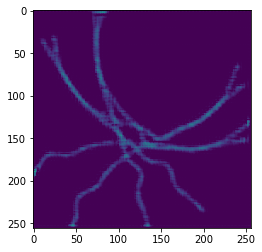

In [14]:
plt.imshow(imgMMSE)
plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
plt.show()

In [15]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:-100.12311
Max value of predicted img:101.40057


In [16]:
print("Min value of predicted img:"+str(np.min(signal[0])))
print("Max value of predicted img:"+str(np.max(signal[0])))

Min value of predicted img:0.0
Max value of predicted img:320.63837


100%|██████████| 100/100 [00:00<00:00, 534.89it/s]


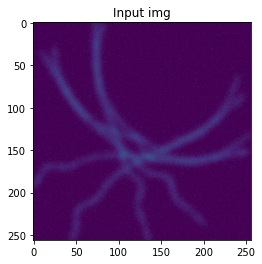

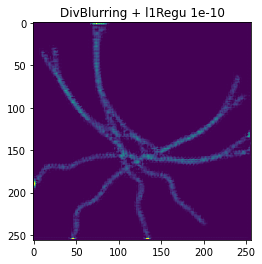

100%|██████████| 100/100 [00:00<00:00, 670.83it/s]

The mean value of PSNR 100 predictions:27.20994459180236


In [17]:
#Save imgs


model_name = 'models_DivBlurring_l1Regu_1e10' # a name used to identify the model
basedir = 'models_DivBlurring_l1Regu_1e10' # the base directory in which our model will live

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

for i in range(1):
    plt.title(label='Input img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='DivBlurring + l1Regu 1e-10')
    plt.imshow(imgMMSE)
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

# import numpy as np
# from PIL import Image

# array = imgMMSE
# array = np.reshape(array, (256,256))

# im = Image.fromarray(array)
# if im.mode != 'RGB':
#     im = im.convert('RGB')
# im.save("DivBlurring.jpeg")


psnr= []
for i in range(100):
    imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
    psnr_i = PSNR(signal[i],imgMMSE)
    psnr.append(psnr_i)

print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

In [18]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:-203.82805
Max value of predicted img:228.55269


100%|██████████| 100/100 [00:00<00:00, 659.04it/s]


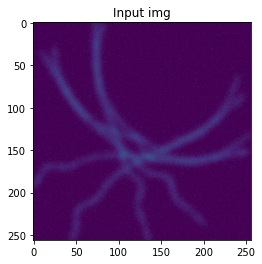

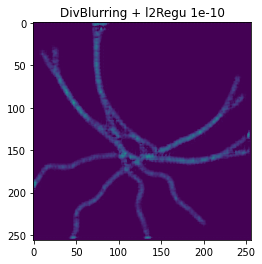

100%|██████████| 100/100 [00:00<00:00, 681.60it/s]


The mean value of PSNR 100 predictions:27.639794820770593


In [19]:
#Save imgs


model_name = 'models_DivBlurring_l2Regu_1e10' # a name used to identify the model
basedir = 'models_DivBlurring_l2Regu_1e10' # the base directory in which our model will live

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

for i in range(1):
    plt.title(label='Input img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='DivBlurring + l2Regu 1e-10')
    plt.imshow(imgMMSE)
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

# import numpy as np
# from PIL import Image

# array = imgMMSE
# array = np.reshape(array, (256,256))

# im = Image.fromarray(array)
# if im.mode != 'RGB':
#     im = im.convert('RGB')
# im.save("DivBlurring.jpeg")


psnr= []
for i in range(100):
    imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
    psnr_i = PSNR(signal[i],imgMMSE)
    psnr.append(psnr_i)

print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

In [20]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:-90.33383
Max value of predicted img:84.77156


100%|██████████| 100/100 [00:00<00:00, 669.71it/s]


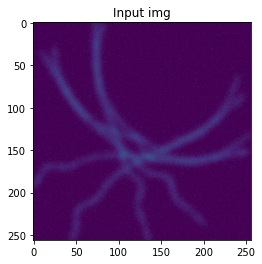

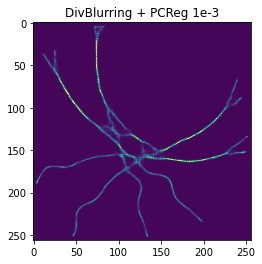

100%|██████████| 100/100 [00:00<00:00, 672.47it/s]

The mean value of PSNR 100 predictions:27.312662931485633


In [21]:
#Save imgs


model_name = 'models_DivBlurring_PCReg_1e3' # a name used to identify the model
basedir = 'models_DivBlurring_PCReg_1e3' # the base directory in which our model will live

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

for i in range(1):
    plt.title(label='Input img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='DivBlurring + PCReg 1e-3')
    plt.imshow(imgMMSE)
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

# import numpy as np
# from PIL import Image

# array = imgMMSE
# array = np.reshape(array, (256,256))

# im = Image.fromarray(array)
# if im.mode != 'RGB':
#     im = im.convert('RGB')
# im.save("DivBlurring.jpeg")


psnr= []
for i in range(100):
    imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
    psnr_i = PSNR(signal[i],imgMMSE)
    psnr.append(psnr_i)

print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

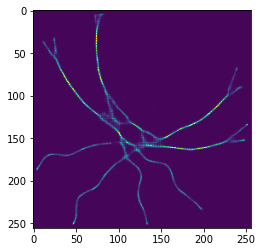

In [22]:
plt.imshow(imgMMSE)
plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
plt.show()

In [23]:
imgMMSE

array([[2.3015451, 2.3096151, 2.3096151, ..., 2.3096151, 2.3096151,
        2.3111417],
       [2.3095205, 2.3096774, 2.3096774, ..., 2.3096774, 2.3096774,
        2.3093069],
       [2.3095205, 2.3096774, 2.3096774, ..., 2.3096774, 2.3096774,
        2.3093069],
       ...,
       [2.3095205, 2.3096774, 2.3096774, ..., 2.3096774, 2.3096774,
        2.3093069],
       [2.3095205, 2.3096774, 2.3096774, ..., 2.3096774, 2.3096774,
        2.3093069],
       [2.3094332, 2.309418 , 2.309418 , ..., 2.309418 , 2.309418 ,
        2.3083792]], dtype=float32)

In [24]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:2.3008382
Max value of predicted img:197.99709


100%|██████████| 100/100 [00:00<00:00, 486.89it/s]


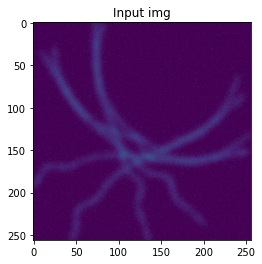

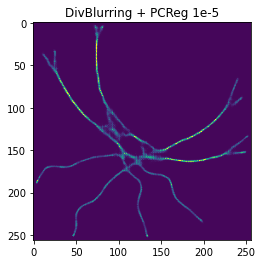

100%|██████████| 100/100 [00:00<00:00, 682.60it/s]


The mean value of PSNR 100 predictions:27.454947290586198


In [26]:
#Save imgs


model_name = 'models_DivBlurring_PCReg_1e5' # a name used to identify the model
basedir = 'models_DivBlurring_PCReg_1e5' # the base directory in which our model will live

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

for i in range(1):
    plt.title(label='Input img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='DivBlurring + PCReg 1e-5')
    plt.imshow(imgMMSE)
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

# import numpy as np
# from PIL import Image

# array = imgMMSE
# array = np.reshape(array, (256,256))

# im = Image.fromarray(array)
# if im.mode != 'RGB':
#     im = im.convert('RGB')
# im.save("DivBlurring.jpeg")


psnr= []
for i in range(100):
    imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
    psnr_i = PSNR(signal[i],imgMMSE)
    psnr.append(psnr_i)

print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

In [27]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:2.012421
Max value of predicted img:236.43639


In [28]:
# #Save imgs


# model_name = 'models_DivBlurring_PCReg_1e10' # a name used to identify the model
# basedir = 'models_DivBlurring_PCReg_1e10' # the base directory in which our model will live

# name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
# vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
# if not torch.cuda.is_available():
#     raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
# else:
#     vae.to(device)

# i = 8
# noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

# signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

# imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

# for i in range(1):
#     plt.title(label='Input img')
#     plt.imshow(noisy_input[i])
#     plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
#     plt.show()
#     plt.title(label='DivBlurring + PCReg 1e-10')
#     plt.imshow(imgMMSE)
#     plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
#     plt.show()

# # import numpy as np
# # from PIL import Image

# # array = imgMMSE
# # array = np.reshape(array, (256,256))

# # im = Image.fromarray(array)
# # if im.mode != 'RGB':
# #     im = im.convert('RGB')
# # im.save("DivBlurring.jpeg")


# psnr= []
# for i in range(100):
#     imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
#     psnr_i = PSNR(signal[i],imgMMSE)
#     psnr.append(psnr_i)

# print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

In [29]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:2.012421
Max value of predicted img:236.43639


100%|██████████| 100/100 [00:00<00:00, 676.25it/s]


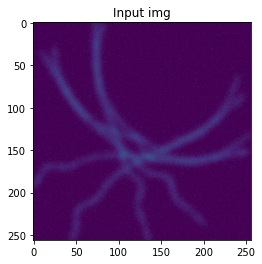

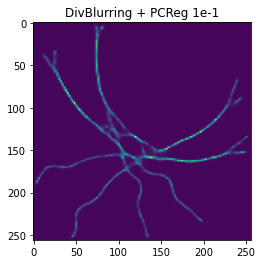

100%|██████████| 100/100 [00:00<00:00, 682.73it/s]


The mean value of PSNR 100 predictions:27.83708319920534


In [30]:
#Save imgs


model_name = 'models_DivBlurring_PCReg_1e1' # a name used to identify the model
basedir = 'models_DivBlurring_PCReg_1e1' # the base directory in which our model will live

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

for i in range(1):
    plt.title(label='Input img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='DivBlurring + PCReg 1e-1')
    plt.imshow(imgMMSE)
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

# import numpy as np
# from PIL import Image

# array = imgMMSE
# array = np.reshape(array, (256,256))

# im = Image.fromarray(array)
# if im.mode != 'RGB':
#     im = im.convert('RGB')
# im.save("DivBlurring.jpeg")


psnr= []
for i in range(100):
    imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
    psnr_i = PSNR(signal[i],imgMMSE)
    psnr.append(psnr_i)

print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

In [31]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:2.3091307
Max value of predicted img:149.76128


100%|██████████| 100/100 [00:00<00:00, 274.28it/s]


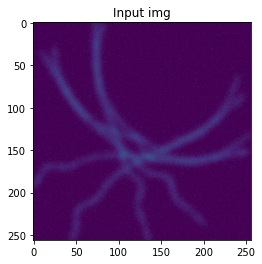

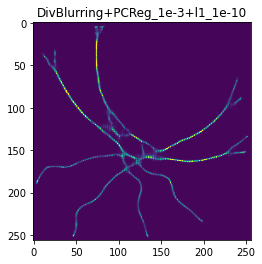

100%|██████████| 100/100 [00:00<00:00, 666.26it/s]

The mean value of PSNR 100 predictions:26.91993062034135


In [10]:
#Save imgs


model_name = 'models_DivBlurring_PC_l1X_Reg_1e3_1e10' # a name used to identify the model
basedir = 'models_DivBlurring_PC_l1X_Reg_1e3_1e10' # the base directory in which our model will live

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

for i in range(1):
    plt.title(label='Input img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='DivBlurring+PCReg_1e-3+l1_1e-10')
    plt.imshow(imgMMSE)
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

# import numpy as np
# from PIL import Image

# array = imgMMSE
# array = np.reshape(array, (256,256))

# im = Image.fromarray(array)
# if im.mode != 'RGB':
#     im = im.convert('RGB')
# im.save("DivBlurring.jpeg")


psnr= []
for i in range(100):
    imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
    psnr_i = PSNR(signal[i],imgMMSE)
    psnr.append(psnr_i)

print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

In [11]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:2.281806
Max value of predicted img:274.09595


In [12]:
imgMMSE

array([[2.3140073, 2.3088257, 2.3088257, ..., 2.3088257, 2.3088257,
        2.3221393],
       [2.3092802, 2.3087454, 2.3087454, ..., 2.3087454, 2.3087454,
        2.3083193],
       [2.3092802, 2.3087454, 2.3087454, ..., 2.3087454, 2.3087454,
        2.3083193],
       ...,
       [2.3092802, 2.3087454, 2.3087454, ..., 2.3087454, 2.3087454,
        2.3083193],
       [2.3092802, 2.3087454, 2.3087454, ..., 2.3087454, 2.3087454,
        2.3083193],
       [2.3222196, 2.3088338, 2.3088338, ..., 2.3088338, 2.3088338,
        2.3055756]], dtype=float32)

100%|██████████| 100/100 [00:00<00:00, 546.24it/s]


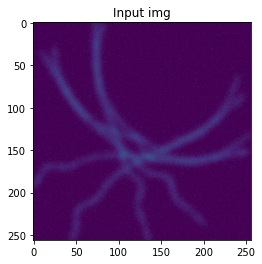

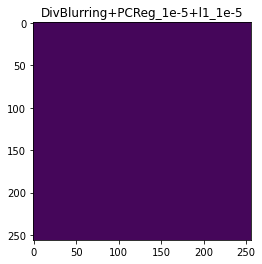

100%|██████████| 100/100 [00:00<00:00, 682.60it/s]

The mean value of PSNR 100 predictions:26.311735121274463


In [34]:
#Save imgs


model_name = 'models_DivBlurring_PC_l1X_Reg_1e5_1e5' # a name used to identify the model
basedir = 'models_DivBlurring_PC_l1X_Reg_1e5_1e5' # the base directory in which our model will live

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

i = 8
noisy_input= imread("./data/data4Sai/"+'BluryNoisy_tubulins_'+str(i)+'_SOFImodel.tif')

signal= imread("./data/data4Sai/"+'tubulins_'+str(i)+'_SOFImodel.tif')

imgMMSE, samps = predict_mmse(vae, noisy_input[0], samples=100, device=device, returnSamples=True)

for i in range(1):
    plt.title(label='Input img')
    plt.imshow(noisy_input[i])
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()
    plt.title(label='DivBlurring+PCReg_1e-5+l1_1e-5')
    plt.imshow(imgMMSE)
    plt.clim(vmin = np.min(signal[0]), vmax =np.max(signal[0])*(0.4))
    plt.show()

# import numpy as np
# from PIL import Image

# array = imgMMSE
# array = np.reshape(array, (256,256))

# im = Image.fromarray(array)
# if im.mode != 'RGB':
#     im = im.convert('RGB')
# im.save("DivBlurring.jpeg")


psnr= []
for i in range(100):
    imgMMSE, samps = predict_mmse(vae, noisy_input[i], samples=100, device=device, returnSamples=True)
    psnr_i = PSNR(signal[i],imgMMSE)
    psnr.append(psnr_i)

print("The mean value of PSNR 100 predictions:"+str(np.mean(psnr)))

In [35]:
print("Min value of predicted img:"+str(np.min(imgMMSE)))
print("Max value of predicted img:"+str(np.max(imgMMSE)))

Min value of predicted img:2.3126528
Max value of predicted img:2.3128653


In [36]:
from tensorboard.backend.event_processing import event_accumulator
import tensorflow as tf
import glob
import pandas as pd
from pandas import DataFrame
from matplotlib.pyplot import axes
all_dfs = {}
models = ['models_DivBlurring','models_DivBlurring_l1Regu_1e10',
'models_DivBlurring_l2Regu_1e10','models_DivBlurring_PCReg_1e3','models_DivBlurring_PCReg_1e5',
'models_DivBlurring_PC_l1X_Reg_1e3_1e10','models_DivBlurring_PC_l1X_Reg_1e5_1e5']
for i in models:
    ea = event_accumulator.EventAccumulator(i, size_guidance={event_accumulator.SCALARS: 0})
    ea.Reload()
    dframes = DataFrame()
    dframes_total = DataFrame()
    mnames = ['reconstruction_loss_epoch', 'kl_loss_epoch', 'training_loss_epoch']


    for n in mnames:
        # print(n)
        dframes = pd.DataFrame(ea.Scalars(n), columns=["wall_time", "epoch", n.replace('val/', '')])
        
        dframes = dframes.drop(columns=['epoch','wall_time'])

        dframes_total[n] = dframes[n]
        dframes = DataFrame()
    
    all_dfs[i] = dframes_total

: 

: 

In [ ]:
import matplotlib.pyplot as plt
for j in mnames:
    for i in models:
        plt.plot(all_dfs[i][j], label = i)


    plt.xlabel('epochs')

    plt.ylabel('loss')
    # giving a title to my graph
    plt.title(j+' Loss values')
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()